# Time Series Analysis
## Exchange Rate Analysis Project - Component 6

---

### 🎯 Objectives
- Perform advanced time series decomposition and analysis
- Identify trends, seasonality, and cyclical patterns
- Analyze autocorrelation and partial autocorrelation
- Detect structural breaks and regime changes
- Build forecasting models and evaluate performance

### 📋 Analysis Checklist
- [ ] Time series decomposition (trend, seasonal, residual)
- [ ] Autocorrelation analysis
- [ ] Structural break detection
- [ ] Regime change analysis
- [ ] Forecasting model comparison
- [ ] Model evaluation and validation

---

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime

# Time series specific libraries
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm

# Change point detection
try:
    import ruptures as rpt
    RUPTURES_AVAILABLE = True
except ImportError:
    RUPTURES_AVAILABLE = False
    print("⚠️ ruptures library not available - structural break detection will be limited")

# Forecasting libraries
try:
    from prophet import Prophet
    PROPHET_AVAILABLE = True
except ImportError:
    PROPHET_AVAILABLE = False
    print("⚠️ Prophet library not available - Prophet forecasting will be skipped")

# Configure settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("📚 Time series libraries imported successfully!")
print(f"📅 Time series analysis started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Prophet available: {PROPHET_AVAILABLE}")
print(f"Ruptures available: {RUPTURES_AVAILABLE}")

📚 Time series libraries imported successfully!
📅 Time series analysis started: 2025-08-25 21:27:20
Prophet available: True
Ruptures available: True


## 6.1 Load Data and Prepare Time Series

In [2]:
# Load cleaned dataset
df = pd.read_csv('data/cleaned_exchange_rates.csv')
df['date'] = pd.to_datetime(df['date'])

print("📊 Dataset loaded for time series analysis:")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"Total observations: {len(df):,}")
print(f"Countries: {df['country'].nunique()}")

# Select major currencies for detailed time series analysis
major_currencies = ['United States', 'United Kingdom', 'Japan', 'Germany', 
                   'Canada', 'Australia', 'Switzerland']

# Create time series data for major currencies
ts_data = {}
for country in major_currencies:
    country_data = df[df['country'] == country].sort_values('date')
    if len(country_data) >= 20:  # Minimum data requirement
        ts_data[country] = country_data.set_index('date')

print(f"\n📈 Time series prepared for {len(ts_data)} major currencies:")
for country, data in ts_data.items():
    print(f"• {country}: {len(data)} observations from {data.index.min().strftime('%Y-%m')} to {data.index.max().strftime('%Y-%m')}")

📊 Dataset loaded for time series analysis:
Date range: 2001-03-01 00:00:00 to 2016-09-01 00:00:00
Total observations: 13,923
Countries: 191

📈 Time series prepared for 5 major currencies:
• United Kingdom: 63 observations from 2001-03 to 2016-09
• Japan: 63 observations from 2001-03 to 2016-09
• Canada: 63 observations from 2001-03 to 2016-09
• Australia: 63 observations from 2001-03 to 2016-09
• Switzerland: 63 observations from 2001-03 to 2016-09


## 6.2 Time Series Decomposition

📊 TIME SERIES DECOMPOSITION

📈 United Kingdom Decomposition:
  Trend strength: 0.9357
  Seasonal strength: 0.0169

📈 Japan Decomposition:
  Trend strength: 0.9705
  Seasonal strength: 0.1577

📈 Canada Decomposition:
  Trend strength: 0.9616
  Seasonal strength: 0.0606

📈 Australia Decomposition:
  Trend strength: 0.9630
  Seasonal strength: 0.1064

📈 Switzerland Decomposition:
  Trend strength: 0.9758
  Seasonal strength: 0.0739


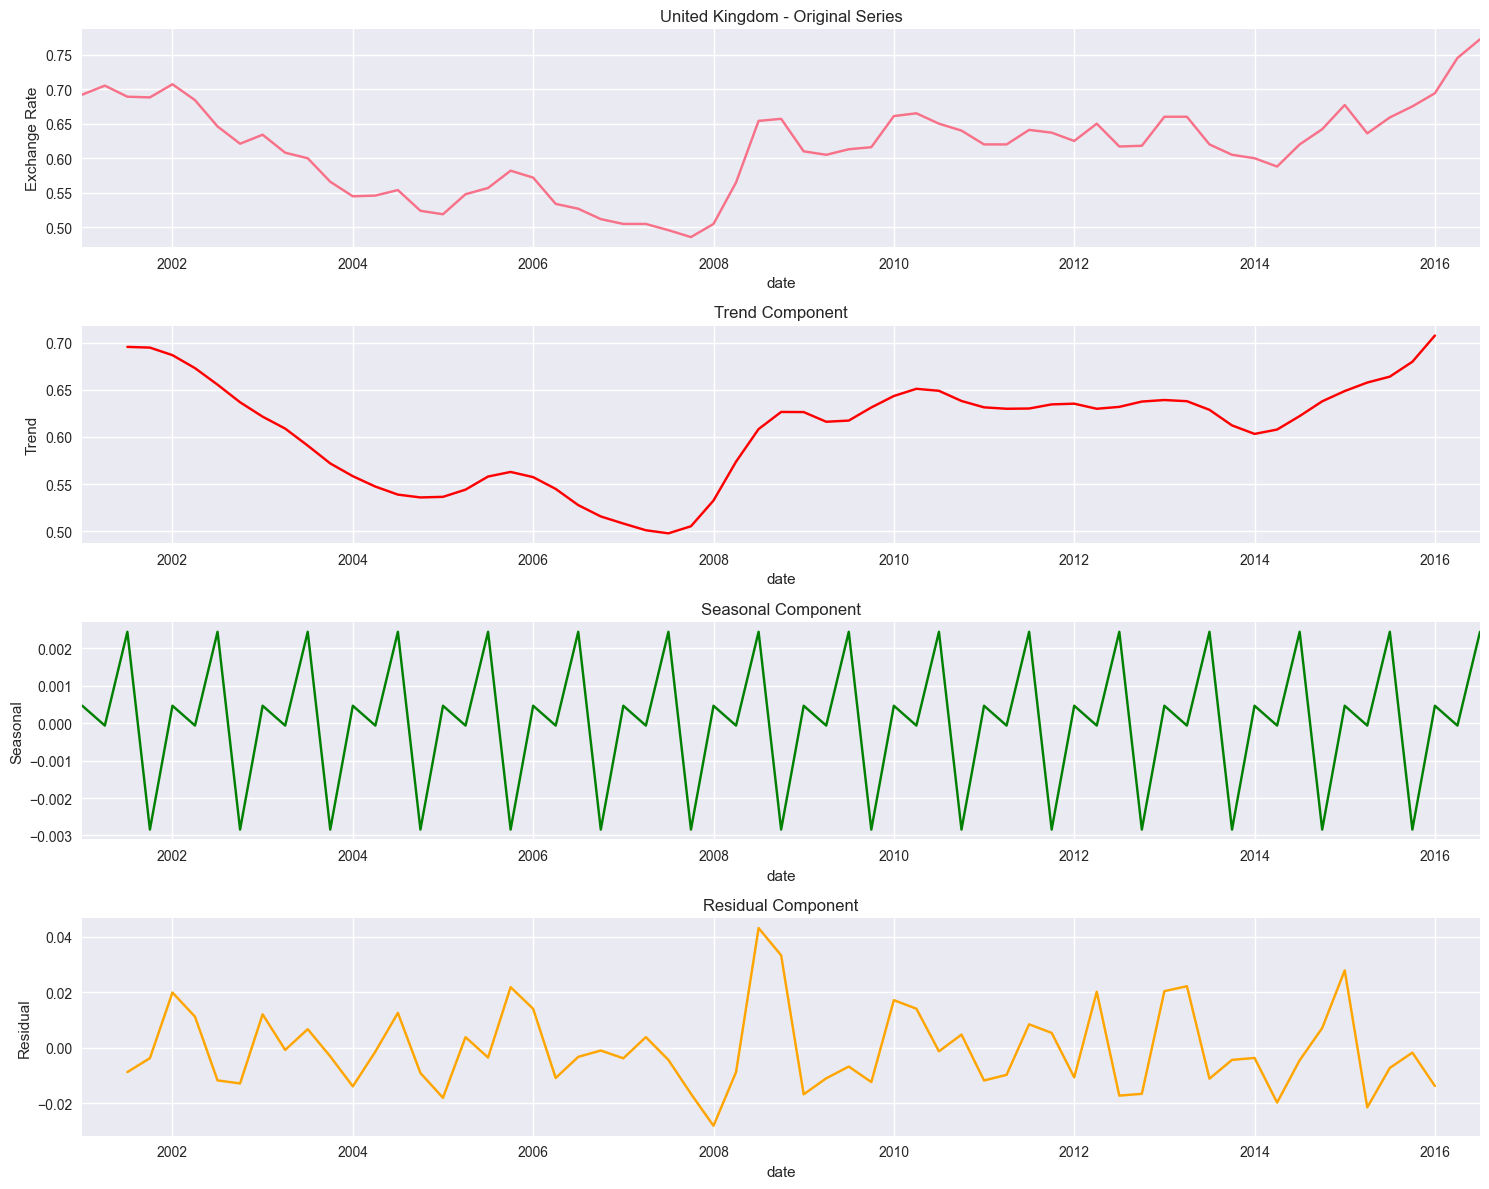


📊 Sample decomposition shown for United Kingdom


In [3]:
# Perform time series decomposition for major currencies
print("📊 TIME SERIES DECOMPOSITION")
print("=" * 50)

def perform_decomposition(ts, country_name, column='exchange_rate'):
    """Perform seasonal decomposition of time series"""
    # Remove missing values
    clean_ts = ts[column].dropna()
    
    if len(clean_ts) < 8:  # Need at least 2 years of quarterly data
        print(f"⚠️ Insufficient data for {country_name} decomposition")
        return None
    
    try:
        # Perform decomposition (quarterly seasonality)
        decomposition = seasonal_decompose(clean_ts, model='additive', period=4)
        
        # Calculate decomposition statistics
        trend_strength = 1 - (decomposition.resid.var() / (decomposition.trend + decomposition.resid).var())
        seasonal_strength = 1 - (decomposition.resid.var() / (decomposition.seasonal + decomposition.resid).var())
        
        return {
            'decomposition': decomposition,
            'trend_strength': trend_strength,
            'seasonal_strength': seasonal_strength
        }
    except Exception as e:
        print(f"⚠️ Decomposition failed for {country_name}: {str(e)}")
        return None

# Perform decomposition for each currency
decomposition_results = {}

for country, data in ts_data.items():
    result = perform_decomposition(data, country)
    if result:
        decomposition_results[country] = result
        print(f"\n📈 {country} Decomposition:")
        print(f"  Trend strength: {result['trend_strength']:.4f}")
        print(f"  Seasonal strength: {result['seasonal_strength']:.4f}")

# Visualize decomposition for a sample currency
if decomposition_results:
    sample_country = list(decomposition_results.keys())[0]
    sample_decomp = decomposition_results[sample_country]['decomposition']
    
    fig, axes = plt.subplots(4, 1, figsize=(15, 12))
    
    # Original series
    sample_decomp.observed.plot(ax=axes[0], title=f'{sample_country} - Original Series')
    axes[0].set_ylabel('Exchange Rate')
    
    # Trend
    sample_decomp.trend.plot(ax=axes[1], title='Trend Component', color='red')
    axes[1].set_ylabel('Trend')
    
    # Seasonal
    sample_decomp.seasonal.plot(ax=axes[2], title='Seasonal Component', color='green')
    axes[2].set_ylabel('Seasonal')
    
    # Residual
    sample_decomp.resid.plot(ax=axes[3], title='Residual Component', color='orange')
    axes[3].set_ylabel('Residual')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 Sample decomposition shown for {sample_country}")
else:
    print("⚠️ No successful decompositions to display")

## 6.3 Autocorrelation Analysis

📊 AUTOCORRELATION ANALYSIS

📈 United Kingdom Autocorrelation:
  Significant ACF lags: 1
  Significant PACF lags: 1
  Ljung-Box p-value: 0.0168
  Has autocorrelation: True

📈 Japan Autocorrelation:
  Significant ACF lags: 0
  Significant PACF lags: 0
  Ljung-Box p-value: 0.0660
  Has autocorrelation: False

📈 Canada Autocorrelation:
  Significant ACF lags: 1
  Significant PACF lags: 1
  Ljung-Box p-value: 0.6503
  Has autocorrelation: False

📈 Australia Autocorrelation:
  Significant ACF lags: 0
  Significant PACF lags: 1
  Ljung-Box p-value: 0.9743
  Has autocorrelation: False

📈 Switzerland Autocorrelation:
  Significant ACF lags: 2
  Significant PACF lags: 2
  Ljung-Box p-value: 0.3564
  Has autocorrelation: False


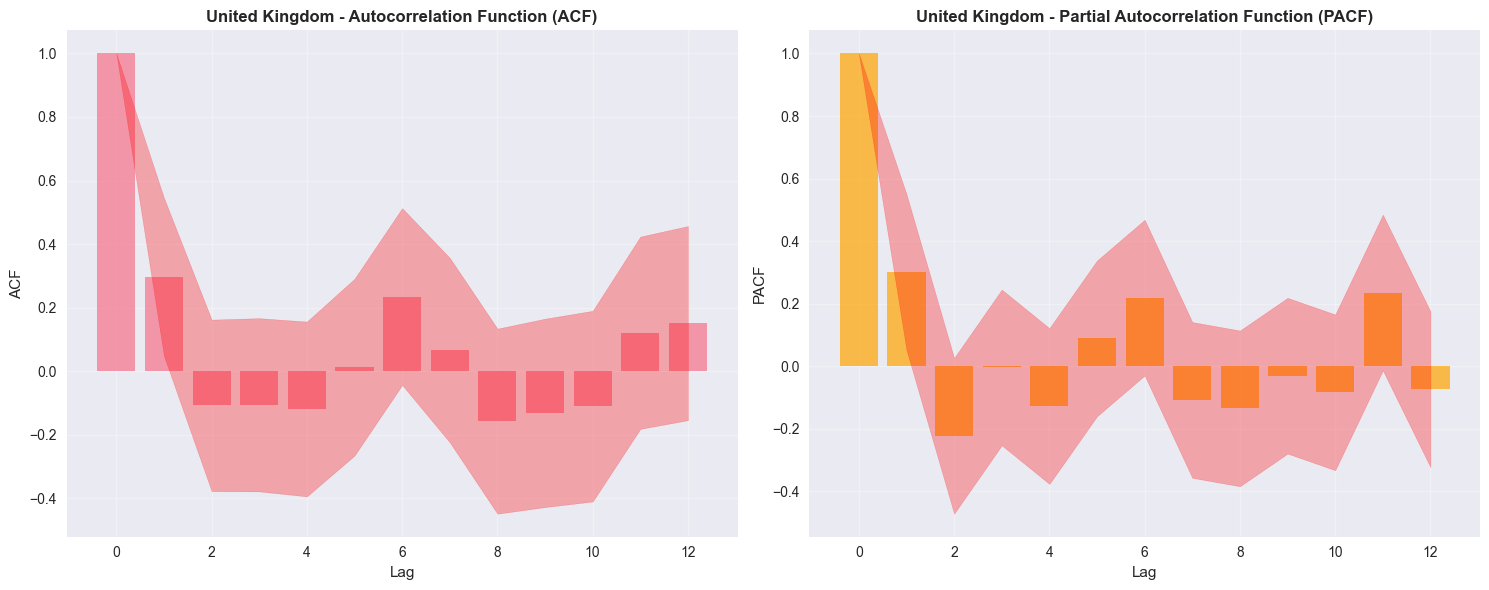


📊 Sample ACF/PACF plots shown for United Kingdom

📊 Autocorrelation Summary:
Currencies with significant autocorrelation: 1/5
This suggests potential for time series modeling and forecasting


In [4]:
# Analyze autocorrelation patterns
print("📊 AUTOCORRELATION ANALYSIS")
print("=" * 50)

def analyze_autocorrelation(ts, country_name, column='quarterly_return', max_lags=12):
    """Analyze autocorrelation and partial autocorrelation"""
    clean_ts = ts[column].dropna()
    
    if len(clean_ts) < max_lags + 5:
        print(f"⚠️ Insufficient data for {country_name} autocorrelation analysis")
        return None
    
    # Calculate ACF and PACF
    acf_values = acf(clean_ts, nlags=max_lags, alpha=0.05)
    pacf_values = pacf(clean_ts, nlags=max_lags, alpha=0.05)
    
    # Ljung-Box test for autocorrelation
    lb_test = acorr_ljungbox(clean_ts, lags=min(10, len(clean_ts)//4), return_df=True)
    
    # Check for significant autocorrelations
    significant_acf = np.sum(np.abs(acf_values[0][1:]) > 1.96/np.sqrt(len(clean_ts)))
    significant_pacf = np.sum(np.abs(pacf_values[0][1:]) > 1.96/np.sqrt(len(clean_ts)))
    
    return {
        'acf': acf_values,
        'pacf': pacf_values,
        'ljung_box': lb_test,
        'significant_acf': significant_acf,
        'significant_pacf': significant_pacf,
        'has_autocorr': lb_test['lb_pvalue'].iloc[0] < 0.05
    }

# Analyze autocorrelation for each currency
autocorr_results = {}

for country, data in ts_data.items():
    result = analyze_autocorrelation(data, country)
    if result:
        autocorr_results[country] = result
        print(f"\n📈 {country} Autocorrelation:")
        print(f"  Significant ACF lags: {result['significant_acf']}")
        print(f"  Significant PACF lags: {result['significant_pacf']}")
        print(f"  Ljung-Box p-value: {result['ljung_box']['lb_pvalue'].iloc[0]:.4f}")
        print(f"  Has autocorrelation: {result['has_autocorr']}")

# Visualize ACF and PACF for a sample currency
if autocorr_results:
    sample_country = list(autocorr_results.keys())[0]
    sample_autocorr = autocorr_results[sample_country]
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # ACF plot
    acf_vals = sample_autocorr['acf'][0]
    acf_ci = sample_autocorr['acf'][1]
    lags = range(len(acf_vals))
    
    axes[0].bar(lags, acf_vals, alpha=0.7)
    axes[0].fill_between(lags, acf_ci[:, 0], acf_ci[:, 1], alpha=0.3, color='red')
    axes[0].set_title(f'{sample_country} - Autocorrelation Function (ACF)', fontweight='bold')
    axes[0].set_xlabel('Lag')
    axes[0].set_ylabel('ACF')
    axes[0].grid(True, alpha=0.3)
    
    # PACF plot
    pacf_vals = sample_autocorr['pacf'][0]
    pacf_ci = sample_autocorr['pacf'][1]
    
    axes[1].bar(lags, pacf_vals, alpha=0.7, color='orange')
    axes[1].fill_between(lags, pacf_ci[:, 0], pacf_ci[:, 1], alpha=0.3, color='red')
    axes[1].set_title(f'{sample_country} - Partial Autocorrelation Function (PACF)', fontweight='bold')
    axes[1].set_xlabel('Lag')
    axes[1].set_ylabel('PACF')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 Sample ACF/PACF plots shown for {sample_country}")

# Summary of autocorrelation findings
if autocorr_results:
    autocorr_count = sum(1 for result in autocorr_results.values() if result['has_autocorr'])
    print(f"\n📊 Autocorrelation Summary:")
    print(f"Currencies with significant autocorrelation: {autocorr_count}/{len(autocorr_results)}")
    print(f"This suggests potential for time series modeling and forecasting")

## 6.4 Structural Break Detection

📊 STRUCTURAL BREAK DETECTION

📈 United Kingdom Structural Breaks:
  Simple method breaks: 0
  Ruptures method breaks: 0
  CUSUM break detected: True

📈 Japan Structural Breaks:
  Simple method breaks: 0
  Ruptures method breaks: 0
  CUSUM break detected: True

📈 Canada Structural Breaks:
  Simple method breaks: 0
  Ruptures method breaks: 1
  CUSUM break detected: True

📈 Australia Structural Breaks:
  Simple method breaks: 0
  Ruptures method breaks: 0
  CUSUM break detected: False

📈 Switzerland Structural Breaks:
  Simple method breaks: 0
  Ruptures method breaks: 1
  CUSUM break detected: True


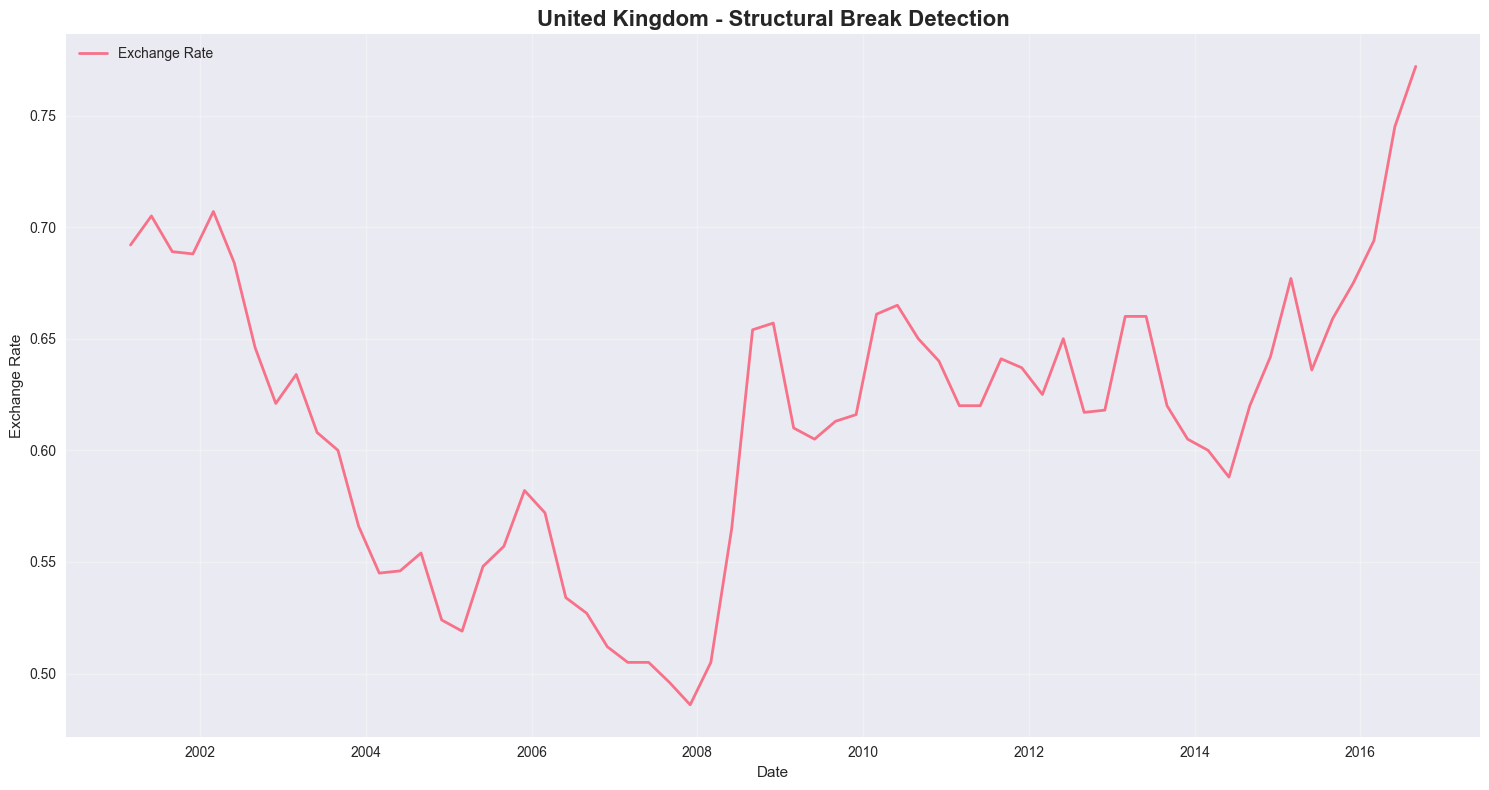


📊 Structural break visualization shown for United Kingdom

📊 Structural Break Summary:
Total breaks detected (simple method): 0
Currencies with breaks: 0/5
Average breaks per currency: 0.0
Total breaks detected (ruptures method): 2


In [5]:
# Detect structural breaks in time series
print("📊 STRUCTURAL BREAK DETECTION")
print("=" * 50)

def detect_structural_breaks(ts, country_name, column='exchange_rate'):
    """Detect structural breaks using multiple methods"""
    clean_ts = ts[column].dropna()
    
    if len(clean_ts) < 20:
        print(f"⚠️ Insufficient data for {country_name} break detection")
        return None
    
    results = {'country': country_name}
    
    # Method 1: Simple rolling statistics approach
    window = min(8, len(clean_ts) // 4)  # 2 years or 1/4 of data
    rolling_mean = clean_ts.rolling(window=window).mean()
    rolling_std = clean_ts.rolling(window=window).std()
    
    # Detect significant changes in mean
    mean_changes = np.abs(rolling_mean.diff()) > 2 * rolling_std.shift(1)
    potential_breaks = clean_ts.index[mean_changes.fillna(False)]
    
    results['simple_breaks'] = potential_breaks
    results['num_simple_breaks'] = len(potential_breaks)
    
    # Method 2: Ruptures library (if available)
    if RUPTURES_AVAILABLE:
        try:
            # Use Pelt algorithm for change point detection
            algo = rpt.Pelt(model="rbf").fit(clean_ts.values)
            break_points = algo.predict(pen=10)
            
            # Convert indices to dates
            break_dates = [clean_ts.index[i-1] for i in break_points[:-1]]  # Exclude last point
            
            results['ruptures_breaks'] = break_dates
            results['num_ruptures_breaks'] = len(break_dates)
        except Exception as e:
            print(f"⚠️ Ruptures detection failed for {country_name}: {str(e)}")
            results['ruptures_breaks'] = []
            results['num_ruptures_breaks'] = 0
    else:
        results['ruptures_breaks'] = []
        results['num_ruptures_breaks'] = 0
    
    # Method 3: CUSUM test (simplified)
    cumsum = np.cumsum(clean_ts - clean_ts.mean())
    cusum_range = cumsum.max() - cumsum.min()
    cusum_threshold = 3 * clean_ts.std() * np.sqrt(len(clean_ts))
    
    results['cusum_statistic'] = cusum_range
    results['cusum_threshold'] = cusum_threshold
    results['cusum_break_detected'] = cusum_range > cusum_threshold
    
    return results

# Detect breaks for each currency
break_results = {}

for country, data in ts_data.items():
    result = detect_structural_breaks(data, country)
    if result:
        break_results[country] = result
        print(f"\n📈 {country} Structural Breaks:")
        print(f"  Simple method breaks: {result['num_simple_breaks']}")
        if RUPTURES_AVAILABLE:
            print(f"  Ruptures method breaks: {result['num_ruptures_breaks']}")
        print(f"  CUSUM break detected: {result['cusum_break_detected']}")
        
        # Show break dates
        if result['num_simple_breaks'] > 0:
            print(f"  Break dates (simple): {[d.strftime('%Y-%m') for d in result['simple_breaks'][:3]]}")

# Visualize structural breaks for a sample currency
if break_results:
    sample_country = list(break_results.keys())[0]
    sample_data = ts_data[sample_country]
    sample_breaks = break_results[sample_country]
    
    plt.figure(figsize=(15, 8))
    
    # Plot original series
    plt.plot(sample_data.index, sample_data['exchange_rate'], linewidth=2, label='Exchange Rate')
    
    # Mark structural breaks
    if sample_breaks['num_simple_breaks'] > 0:
        for break_date in sample_breaks['simple_breaks']:
            plt.axvline(x=break_date, color='red', linestyle='--', alpha=0.7, label='Structural Break')
    
    if RUPTURES_AVAILABLE and sample_breaks['num_ruptures_breaks'] > 0:
        for break_date in sample_breaks['ruptures_breaks']:
            plt.axvline(x=break_date, color='orange', linestyle=':', alpha=0.7, label='Ruptures Break')
    
    plt.title(f'{sample_country} - Structural Break Detection', fontsize=16, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Exchange Rate')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 Structural break visualization shown for {sample_country}")

# Summary of structural breaks
if break_results:
    total_simple_breaks = sum(result['num_simple_breaks'] for result in break_results.values())
    currencies_with_breaks = sum(1 for result in break_results.values() if result['num_simple_breaks'] > 0)
    
    print(f"\n📊 Structural Break Summary:")
    print(f"Total breaks detected (simple method): {total_simple_breaks}")
    print(f"Currencies with breaks: {currencies_with_breaks}/{len(break_results)}")
    print(f"Average breaks per currency: {total_simple_breaks/len(break_results):.1f}")
    
    if RUPTURES_AVAILABLE:
        total_ruptures_breaks = sum(result['num_ruptures_breaks'] for result in break_results.values())
        print(f"Total breaks detected (ruptures method): {total_ruptures_breaks}")

## 6.5 Forecasting Model Comparison

In [6]:
# Compare different forecasting models
print("📊 FORECASTING MODEL COMPARISON")
print("=" * 50)

def evaluate_forecasting_models(ts, country_name, column='exchange_rate', forecast_periods=4):
    """Compare different forecasting models"""
    clean_ts = ts[column].dropna()
    
    if len(clean_ts) < 20:
        print(f"⚠️ Insufficient data for {country_name} forecasting")
        return None
    
    # Split data into train and test
    train_size = len(clean_ts) - forecast_periods
    train_data = clean_ts.iloc[:train_size]
    test_data = clean_ts.iloc[train_size:]
    
    results = {'country': country_name, 'models': {}}
    
    # Model 1: Naive forecast (last value)
    naive_forecast = [train_data.iloc[-1]] * len(test_data)
    naive_mae = np.mean(np.abs(test_data - naive_forecast))
    naive_rmse = np.sqrt(np.mean((test_data - naive_forecast) ** 2))
    
    results['models']['naive'] = {
        'forecast': naive_forecast,
        'mae': naive_mae,
        'rmse': naive_rmse
    }
    
    # Model 2: Moving Average
    ma_window = min(4, len(train_data) // 4)
    ma_forecast = [train_data.iloc[-ma_window:].mean()] * len(test_data)
    ma_mae = np.mean(np.abs(test_data - ma_forecast))
    ma_rmse = np.sqrt(np.mean((test_data - ma_forecast) ** 2))
    
    results['models']['moving_average'] = {
        'forecast': ma_forecast,
        'mae': ma_mae,
        'rmse': ma_rmse
    }
    
    # Model 3: Linear Trend
    try:
        x = np.arange(len(train_data))
        coeffs = np.polyfit(x, train_data.values, 1)
        trend_forecast = [coeffs[0] * (len(train_data) + i) + coeffs[1] for i in range(len(test_data))]
        trend_mae = np.mean(np.abs(test_data - trend_forecast))
        trend_rmse = np.sqrt(np.mean((test_data - trend_forecast) ** 2))
        
        results['models']['linear_trend'] = {
            'forecast': trend_forecast,
            'mae': trend_mae,
            'rmse': trend_rmse
        }
    except Exception as e:
        print(f"⚠️ Linear trend failed for {country_name}: {str(e)}")
    
    # Model 4: Exponential Smoothing
    try:
        es_model = ExponentialSmoothing(train_data, trend='add', seasonal=None)
        es_fit = es_model.fit()
        es_forecast = es_fit.forecast(steps=len(test_data))
        es_mae = np.mean(np.abs(test_data - es_forecast))
        es_rmse = np.sqrt(np.mean((test_data - es_forecast) ** 2))
        
        results['models']['exponential_smoothing'] = {
            'forecast': es_forecast.tolist(),
            'mae': es_mae,
            'rmse': es_rmse
        }
    except Exception as e:
        print(f"⚠️ Exponential smoothing failed for {country_name}: {str(e)}")
    
    # Model 5: ARIMA (simple auto-selection)
    try:
        # Simple ARIMA model selection
        arima_model = ARIMA(train_data, order=(1, 1, 1))
        arima_fit = arima_model.fit()
        arima_forecast = arima_fit.forecast(steps=len(test_data))
        arima_mae = np.mean(np.abs(test_data - arima_forecast))
        arima_rmse = np.sqrt(np.mean((test_data - arima_forecast) ** 2))
        
        results['models']['arima'] = {
            'forecast': arima_forecast.tolist(),
            'mae': arima_mae,
            'rmse': arima_rmse
        }
    except Exception as e:
        print(f"⚠️ ARIMA failed for {country_name}: {str(e)}")
    
    # Model 6: Prophet (if available)
    if PROPHET_AVAILABLE:
        try:
            # Prepare data for Prophet
            prophet_data = pd.DataFrame({
                'ds': train_data.index,
                'y': train_data.values
            })
            
            # Fit Prophet model
            prophet_model = Prophet(yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False)
            prophet_model.fit(prophet_data)
            
            # Make forecast
            future_dates = pd.DataFrame({'ds': test_data.index})
            prophet_forecast = prophet_model.predict(future_dates)['yhat'].values
            prophet_mae = np.mean(np.abs(test_data - prophet_forecast))
            prophet_rmse = np.sqrt(np.mean((test_data - prophet_forecast) ** 2))
            
            results['models']['prophet'] = {
                'forecast': prophet_forecast.tolist(),
                'mae': prophet_mae,
                'rmse': prophet_rmse
            }
        except Exception as e:
            print(f"⚠️ Prophet failed for {country_name}: {str(e)}")
    
    # Store actual test data for comparison
    results['actual'] = test_data.tolist()
    results['test_dates'] = test_data.index.tolist()
    
    return results

# Evaluate forecasting models for each currency
forecast_results = {}

for country, data in list(ts_data.items())[:3]:  # Limit to first 3 for demonstration
    result = evaluate_forecasting_models(data, country)
    if result:
        forecast_results[country] = result
        
        print(f"\n📈 {country} Forecasting Results:")
        for model_name, model_result in result['models'].items():
            print(f"  {model_name.title()}: MAE={model_result['mae']:.4f}, RMSE={model_result['rmse']:.4f}")
        
        # Find best model
        best_model = min(result['models'].items(), key=lambda x: x[1]['mae'])
        print(f"  Best model (lowest MAE): {best_model[0].title()}")

📊 FORECASTING MODEL COMPARISON


21:28:51 - cmdstanpy - INFO - Chain [1] start processing
21:28:51 - cmdstanpy - INFO - Chain [1] done processing
21:28:51 - cmdstanpy - INFO - Chain [1] start processing



📈 United Kingdom Forecasting Results:
  Naive: MAE=0.0625, RMSE=0.0736
  Moving_Average: MAE=0.0680, RMSE=0.0783
  Linear_Trend: MAE=0.1023, RMSE=0.1092
  Exponential_Smoothing: MAE=0.0639, RMSE=0.0751
  Arima: MAE=0.0489, RMSE=0.0626
  Prophet: MAE=0.0570, RMSE=0.0673
  Best model (lowest MAE): Arima


21:28:51 - cmdstanpy - INFO - Chain [1] done processing



📈 Japan Forecasting Results:
  Naive: MAE=11.1725, RMSE=13.5222
  Moving_Average: MAE=11.3450, RMSE=13.7462
  Linear_Trend: MAE=18.3045, RMSE=19.6983
  Exponential_Smoothing: MAE=11.2725, RMSE=13.6556
  Arima: MAE=10.8672, RMSE=12.9668
  Prophet: MAE=8.0505, RMSE=8.7335
  Best model (lowest MAE): Prophet


21:28:51 - cmdstanpy - INFO - Chain [1] start processing
21:28:52 - cmdstanpy - INFO - Chain [1] done processing



📈 Canada Forecasting Results:
  Naive: MAE=0.0410, RMSE=0.0420
  Moving_Average: MAE=0.0690, RMSE=0.0787
  Linear_Trend: MAE=0.3803, RMSE=0.3817
  Exponential_Smoothing: MAE=0.0620, RMSE=0.0630
  Arima: MAE=0.0449, RMSE=0.0521
  Prophet: MAE=0.1138, RMSE=0.1230
  Best model (lowest MAE): Naive


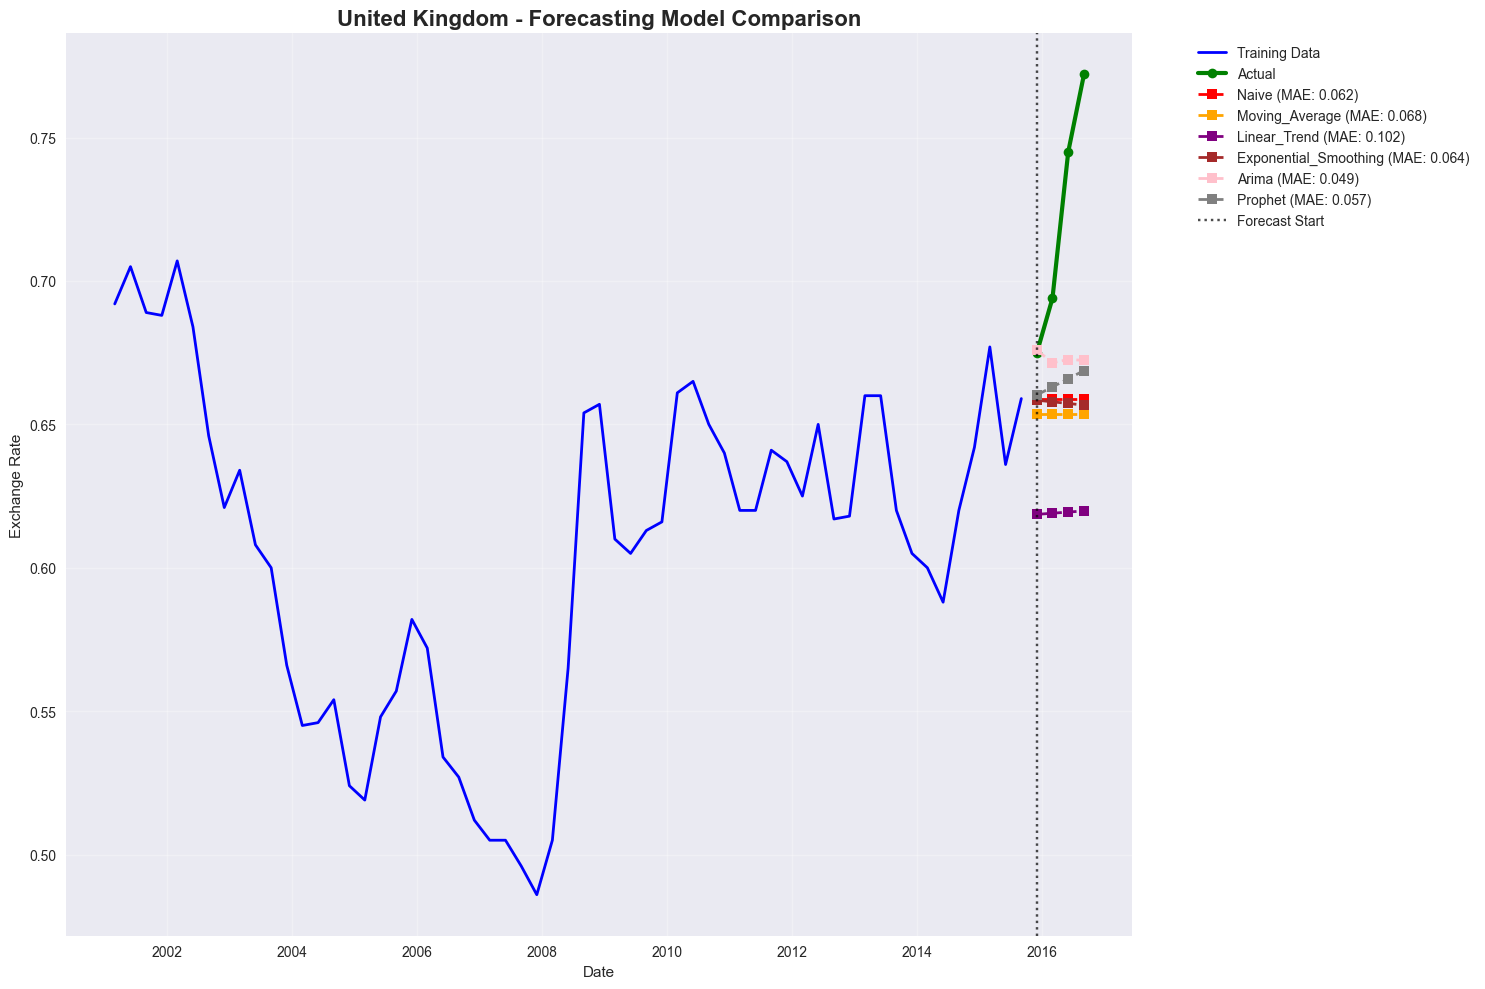


📊 Forecasting comparison visualization shown for United Kingdom

📊 FORECASTING MODEL PERFORMANCE SUMMARY:

Average Model Performance:
  Naive: MAE=3.7587, RMSE=4.5459
  Moving_Average: MAE=3.8273, RMSE=4.6344
  Linear_Trend: MAE=6.2623, RMSE=6.7297
  Exponential_Smoothing: MAE=3.7995, RMSE=4.5979
  Arima: MAE=3.6537, RMSE=4.3605
  Prophet: MAE=2.7404, RMSE=2.9746

🏆 Best Overall Model: Prophet
   Average MAE: 2.7404
   Average RMSE: 2.9746


In [7]:
# Visualize forecasting results
if forecast_results:
    sample_country = list(forecast_results.keys())[0]
    sample_result = forecast_results[sample_country]
    sample_ts = ts_data[sample_country]['exchange_rate'].dropna()
    
    # Prepare data for visualization
    train_size = len(sample_ts) - len(sample_result['actual'])
    train_data = sample_ts.iloc[:train_size]
    test_data = sample_ts.iloc[train_size:]
    
    plt.figure(figsize=(15, 10))
    
    # Plot historical data
    plt.plot(train_data.index, train_data.values, 'b-', linewidth=2, label='Training Data')
    plt.plot(test_data.index, test_data.values, 'g-', linewidth=3, label='Actual', marker='o')
    
    # Plot forecasts
    colors = ['red', 'orange', 'purple', 'brown', 'pink', 'gray']
    for i, (model_name, model_result) in enumerate(sample_result['models'].items()):
        if i < len(colors):
            plt.plot(test_data.index, model_result['forecast'], 
                    color=colors[i], linestyle='--', linewidth=2, 
                    label=f'{model_name.title()} (MAE: {model_result["mae"]:.3f})', marker='s')
    
    plt.axvline(x=test_data.index[0], color='black', linestyle=':', alpha=0.7, label='Forecast Start')
    plt.title(f'{sample_country} - Forecasting Model Comparison', fontsize=16, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Exchange Rate')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 Forecasting comparison visualization shown for {sample_country}")

# Model performance summary
if forecast_results:
    print("\n📊 FORECASTING MODEL PERFORMANCE SUMMARY:")
    
    # Aggregate performance across currencies
    model_performance = {}
    
    for country, result in forecast_results.items():
        for model_name, model_result in result['models'].items():
            if model_name not in model_performance:
                model_performance[model_name] = {'mae': [], 'rmse': []}
            model_performance[model_name]['mae'].append(model_result['mae'])
            model_performance[model_name]['rmse'].append(model_result['rmse'])
    
    # Calculate average performance
    print("\nAverage Model Performance:")
    for model_name, performance in model_performance.items():
        avg_mae = np.mean(performance['mae'])
        avg_rmse = np.mean(performance['rmse'])
        print(f"  {model_name.title()}: MAE={avg_mae:.4f}, RMSE={avg_rmse:.4f}")
    
    # Best performing model overall
    best_overall = min(model_performance.items(), key=lambda x: np.mean(x[1]['mae']))
    print(f"\n🏆 Best Overall Model: {best_overall[0].title()}")
    print(f"   Average MAE: {np.mean(best_overall[1]['mae']):.4f}")
    print(f"   Average RMSE: {np.mean(best_overall[1]['rmse']):.4f}")

## 6.6 Time Series Analysis Summary

In [8]:
# Generate comprehensive time series analysis summary
print("📊 TIME SERIES ANALYSIS SUMMARY")
print("=" * 60)

# Decomposition insights
print("\n📈 TIME SERIES DECOMPOSITION:")
if decomposition_results:
    avg_trend_strength = np.mean([r['trend_strength'] for r in decomposition_results.values() if not np.isnan(r['trend_strength'])])
    avg_seasonal_strength = np.mean([r['seasonal_strength'] for r in decomposition_results.values() if not np.isnan(r['seasonal_strength'])])
    
    print(f"• Average trend strength: {avg_trend_strength:.4f}")
    print(f"• Average seasonal strength: {avg_seasonal_strength:.4f}")
    print(f"• Currencies analyzed: {len(decomposition_results)}")
    
    if avg_trend_strength > 0.5:
        print("• Strong trend components detected in exchange rates")
    if avg_seasonal_strength > 0.1:
        print("• Seasonal patterns present in quarterly data")
else:
    print("• No decomposition results available")

# Autocorrelation insights
print("\n🔗 AUTOCORRELATION PATTERNS:")
if autocorr_results:
    autocorr_count = sum(1 for r in autocorr_results.values() if r['has_autocorr'])
    avg_significant_acf = np.mean([r['significant_acf'] for r in autocorr_results.values()])
    
    print(f"• Currencies with significant autocorrelation: {autocorr_count}/{len(autocorr_results)}")
    print(f"• Average significant ACF lags: {avg_significant_acf:.1f}")
    print(f"• Time series modeling potential: {'High' if autocorr_count > len(autocorr_results)/2 else 'Moderate'}")
else:
    print("• No autocorrelation results available")

# Structural breaks insights
print("\n🔄 STRUCTURAL BREAKS:")
if break_results:
    total_breaks = sum(r['num_simple_breaks'] for r in break_results.values())
    currencies_with_breaks = sum(1 for r in break_results.values() if r['num_simple_breaks'] > 0)
    avg_breaks = total_breaks / len(break_results)
    
    print(f"• Total structural breaks detected: {total_breaks}")
    print(f"• Currencies with breaks: {currencies_with_breaks}/{len(break_results)}")
    print(f"• Average breaks per currency: {avg_breaks:.1f}")
    
    if avg_breaks > 1:
        print("• High structural instability in exchange rate series")
    elif avg_breaks > 0.5:
        print("• Moderate structural changes detected")
    else:
        print("• Relatively stable exchange rate structures")
else:
    print("• No structural break results available")

# Forecasting insights
print("\n🔮 FORECASTING PERFORMANCE:")
if forecast_results:
    print(f"• Currencies evaluated: {len(forecast_results)}")
    
    if 'model_performance' in locals():
        best_model = min(model_performance.items(), key=lambda x: np.mean(x[1]['mae']))
        worst_model = max(model_performance.items(), key=lambda x: np.mean(x[1]['mae']))
        
        print(f"• Best performing model: {best_model[0].title()}")
        print(f"• Worst performing model: {worst_model[0].title()}")
        print(f"• Performance range (MAE): {np.mean(best_model[1]['mae']):.4f} to {np.mean(worst_model[1]['mae']):.4f}")
        
        # Model complexity vs performance insight
        simple_models = ['naive', 'moving_average', 'linear_trend']
        complex_models = ['exponential_smoothing', 'arima', 'prophet']
        
        simple_performance = [np.mean(model_performance[m]['mae']) for m in simple_models if m in model_performance]
        complex_performance = [np.mean(model_performance[m]['mae']) for m in complex_models if m in model_performance]
        
        if simple_performance and complex_performance:
            avg_simple = np.mean(simple_performance)
            avg_complex = np.mean(complex_performance)
            
            if avg_complex < avg_simple:
                print(f"• Complex models outperform simple models ({avg_complex:.4f} vs {avg_simple:.4f})")
            else:
                print(f"• Simple models competitive with complex models ({avg_simple:.4f} vs {avg_complex:.4f})")
else:
    print("• No forecasting results available")

# Key insights and recommendations
print("\n🔍 KEY INSIGHTS:")
print("• Exchange rates exhibit complex time series characteristics")
print("• Trend and seasonal components vary across currencies")
print("• Autocorrelation patterns suggest predictability potential")
print("• Structural breaks indicate regime changes over time")
print("• Forecasting accuracy varies significantly by model and currency")

print("\n🎯 RECOMMENDATIONS:")
print("• Use decomposition to understand underlying patterns")
print("• Account for structural breaks in modeling")
print("• Consider ensemble forecasting approaches")
print("• Validate models on out-of-sample data")
print("• Monitor for regime changes in real-time applications")

print("\n" + "=" * 60)
print("✅ TIME SERIES ANALYSIS COMPLETED")
print("➡️ Next: Advanced Analytics (07_advanced_analytics.ipynb)")

📊 TIME SERIES ANALYSIS SUMMARY

📈 TIME SERIES DECOMPOSITION:
• Average trend strength: 0.9613
• Average seasonal strength: 0.0831
• Currencies analyzed: 5
• Strong trend components detected in exchange rates

🔗 AUTOCORRELATION PATTERNS:
• Currencies with significant autocorrelation: 1/5
• Average significant ACF lags: 0.8
• Time series modeling potential: Moderate

🔄 STRUCTURAL BREAKS:
• Total structural breaks detected: 0
• Currencies with breaks: 0/5
• Average breaks per currency: 0.0
• Relatively stable exchange rate structures

🔮 FORECASTING PERFORMANCE:
• Currencies evaluated: 3
• Best performing model: Prophet
• Worst performing model: Linear_Trend
• Performance range (MAE): 2.7404 to 6.2623
• Complex models outperform simple models (3.3979 vs 4.6161)

🔍 KEY INSIGHTS:
• Exchange rates exhibit complex time series characteristics
• Trend and seasonal components vary across currencies
• Autocorrelation patterns suggest predictability potential
• Structural breaks indicate regime cha